In [1]:
# change working directory to the project root
import os
os.chdir('../../')

import sys
sys.path.append('models/utils')
sys.path.append('models/brian2')
sys.path.append('models/aln')

In [2]:
# import python packages
from __future__ import print_function
import os
import datetime
import tqdm
import matplotlib.pyplot as plt
% matplotlib inline
import numpy as np
import scipy 
import pandas as pd
import pypet as pp

# import utils libs
import pypet_parameters as pe
import fitparams as fp
import functions as func
import runModels as rm
import paths

In [3]:
# sett dpi for notebooks on server
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['image.cmap'] = 'plasma'

In [5]:
params = []
params = fp.loadpoint(params, "A2")

params['dt'] = 0.1
params['duration'] =  6000 
params['sigma_ou'] = 0.0

N_neurons = 1 # only using aln anyway, not adex network
params['N'] = N_neurons
params['model'] = 'aln'

In [6]:
parametrization = pp.cartesian_product({
    'mue_ext_mean':[ round(elem, 3) for elem in np.linspace(0, 3.0, 31)],
    'mui_ext_mean':[ round(elem, 3) for elem in np.linspace(0, 3.0, 31)],
    'Jee_max':[params['Jee_max']-0.5, params['Jee_max'], params['Jee_max']+0.5],
    'Jii_max':[params['Jii_max']-0.5, params['Jii_max'], params['Jii_max']+0.5],
    'Jei_max':[params['Jei_max']-0.5, params['Jei_max'], params['Jei_max']+0.5],
    'Jie_max':[params['Jie_max']-0.5, params['Jie_max'], params['Jie_max']+0.5]
})

print("{} parameterizations".format(len(parametrization[parametrization.keys()[0]])))

77841 parameterizations


In [7]:
# load test parameters
npar = 198

for k in parametrization:
    print(k, parametrization[k][npar])
    #params[k] = parametrization[k][npar]

Jii_max -2.14
mue_ext_mean 0.0
Jie_max 2.1
Jei_max -2.8
Jee_max 1.93
mui_ext_mean 1.2


In [11]:
# test run
t_test, re_test, ri_test, stimulus_test = rm.runModels_stimulus(manual_params=params)

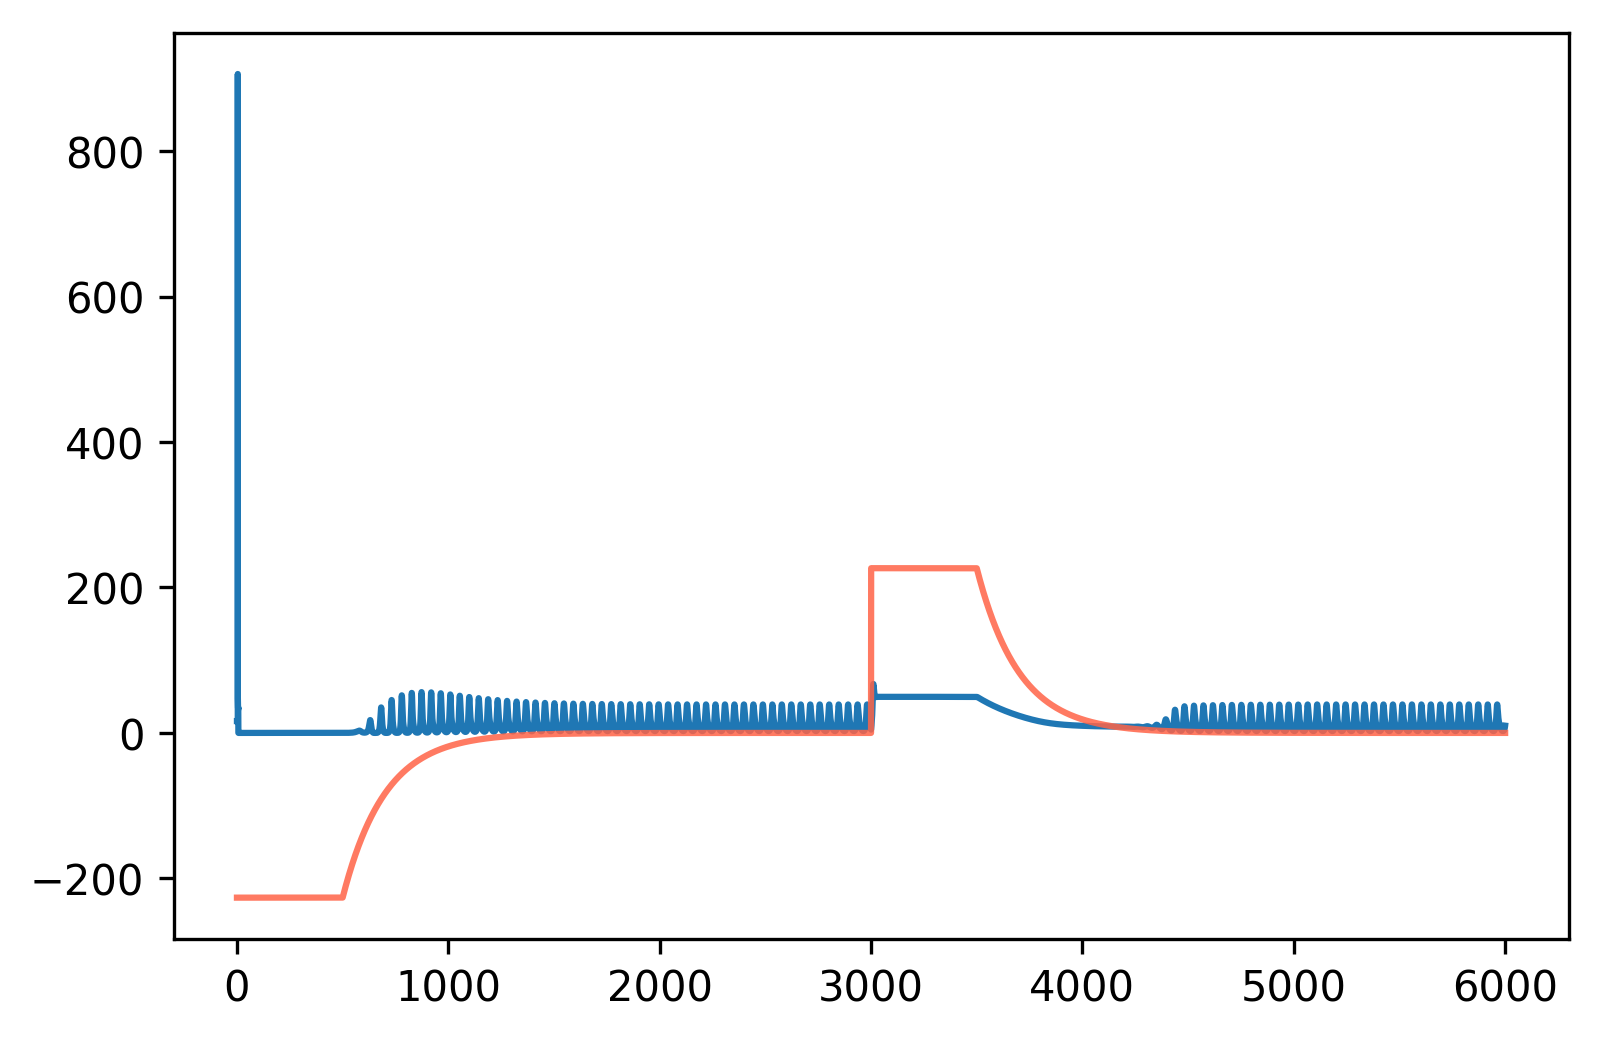

In [12]:
# plot test run
plt.plot(t_test, re_test)
#plt.plot(t_test, ri_test)
plt.plot(t_test[-len(stimulus_test):], stimulus_test/np.max(stimulus_test)*np.max(re_test)/4, alpha=0.85, c='tomato')
plt.show()

In [18]:
# ---- initialize pypet environment ----
trajectoryName = 'results' + datetime.datetime.now().strftime("-%Y-%m-%d-%HH-%MM-%SS")
HDF_FILE = os.path.join(paths.HDF_DIR, 'aln-grid-bifurcation-J.hdf')
trajectoryFileName = HDF_FILE

import multiprocessing
ncores = multiprocessing.cpu_count()
print("Number of cores: {}".format(ncores))

env = pp.Environment(trajectory=trajectoryName,filename=trajectoryFileName,
                    file_title='Brian2 adEx two populations',
                    large_overview_tables=True,
                    multiproc=True,           
                    ncores=ncores,
                    wrap_mode='QUEUE',
                    log_stdout = False
                    )

# Get the trajectory from the environment
traj = env.v_trajectory
trajectoryName = traj.v_name

pe.add_parameters(traj, params)

MainProcess pypet.storageservice.HDF5StorageService INFO     I will use the hdf5 file `/mnt/fastio/cakan/hdf/aln-grid-bifurcation-J.hdf`.
MainProcess pypet.environment.Environment INFO     Environment initialized.


Number of cores: 80


In [ ]:
traj.f_explore(parametrization)
env.f_run(rm.runModels_stimulus)
env.f_disable_logging()
print("Done.")

MainProcess pypet.environment.Environment INFO     I am preparing the Trajectory for the experiment and initialise the store.
MainProcess pypet.environment.Environment INFO     Initialising the storage for the trajectory.
MainProcess pypet.storageservice.HDF5StorageService INFO     Initialising storage or updating meta data of Trajectory `results-2019-04-24-17H-21M-08S`.
MainProcess pypet.storageservice.HDF5StorageService INFO     Finished init or meta data update for `results-2019-04-24-17H-21M-08S`.
MainProcess pypet.environment.Environment INFO     
************************************************************
STARTING runs of trajectory
`results-2019-04-24-17H-21M-08S`.
************************************************************

MainProcess pypet.storageservice.HDF5StorageService INFO     Initialising storage or updating meta data of Trajectory `results-2019-04-24-17H-21M-08S`.
MainProcess pypet.storageservice.HDF5StorageService INFO     Finished init or meta data update for `resu

# Load results

In [13]:
HDF_FILE = os.path.join(paths.HDF_DIR, 'aln-grid-bifurcation-J.hdf')
HDF_FILE = "/mnt/scratch/cakan/hdf/aln-grid-bifurcation-J.hdf"
trajectoryFileName = HDF_FILE

In [14]:
# ---- load pypet trajectory "trajectoryFileName" ----
print("Analyzing File \"{}\"".format(trajectoryFileName))
print("All Trajectories:")
print(pe.getTrajectoryNameInsideFile(trajectoryFileName))
trajectoryName = pe.getTrajectoryNameInsideFile(trajectoryFileName)[-1]

print("Analyzing trajectory \"{}\".".format(trajectoryName))
trajLoaded = pp.Trajectory(trajectoryName,add_time=False)
trajLoaded.f_load(trajectoryName,filename=trajectoryFileName, force=True)
trajLoaded.v_auto_load = True
print("{} results found".format(len(trajLoaded.f_get_results())))

Analyzing File "/mnt/scratch/cakan/hdf/aln-grid-bifurcation-J.hdf"
All Trajectories:
[u'results-2019-04-24-17H-16M-59S', u'results-2019-04-24-17H-21M-08S']
Analyzing trajectory "results-2019-04-24-17H-21M-08S".
77841 results found


# Data analysis

In [15]:
nResults = len(trajLoaded.f_get_run_names()) # number of results in trajectory 
dt = trajLoaded.f_get_parameters()['parameters.simulation.dt'].f_get() # dt of simulation

# ---- explored parameter list ----
exploredParameters = trajLoaded.f_get_explored_parameters()
niceParKeys = [p.split('.')[-1] for p in exploredParameters.keys()]

# ---- lcreate pandas df with results as keys ----
dfResults = pd.DataFrame(columns=niceParKeys,dtype=object)

# range of parameters
for nicep, p in zip(niceParKeys,exploredParameters.keys()):
    dfResults[nicep] = exploredParameters[p].f_get_range()

## Serial processing

In [17]:
# ---- make a dictionary with results ----
resultDicts = []
makeDict = True

#measures = ['domfr_exc', 'domfr_power_exc', 'max_exc', 'min_exc', 'updowndiff_exc', 'domfr_inh','domfr_power_inh', 'max_inh', 'min_inh', 'updowndiff_inh'] 
measures = ['domfr_exc', 'max_exc', 'updowndiff_exc']

for rInd in tqdm.tqdm(range(nResults), total=nResults):
    
    for measure in measures:
        dfResults.loc[rInd, measure] = func.analyse_run(measure, trajLoaded.results[rInd].f_to_dict(), dt)    
    if makeDict:
            resultDicts.append(trajLoaded.results[rInd].f_to_dict())
            
print("done.")

100%|██████████| 77841/77841 [1:50:40<00:00, 13.02it/s]

done.


## Parallel processing

In [16]:
from joblib import Parallel, delayed
import multiprocessing
num_cores = multiprocessing.cpu_count()   

# ---- make a dictionary with results ----
resultDicts = []
makeDict = False
print("Creating results dictionary ...")
runResults = []
for rInd in range(len(dfResults)):
    result = trajLoaded.results[rInd].f_to_dict()
    runResults.append(result)
    if makeDict:
        resultDicts.append(result)
print("done.")

for measure in ['domfr_exc', 'max_exc', 'updowndiff_exc']:
    print("Analysing measure: {}".format(measure))
    parallelResults = Parallel(n_jobs=num_cores)(delayed(func.analyse_run)(measure = measure, result = i, dt = dt) for i in runResults)
    dfResults[measure] = parallelResults
print("done.")

ERROR:pypet.naturalnaming.NaturalNamingInterface:Error while auto-loading `run_00000816` under `results`. I found the item but I could not load the data.


Creating results dictionary ...


KeyboardInterrupt: 

In [25]:
import pickle
file_path_p = os.path.join(paths.PICKLE_DIR, 'aln-grid-J-bifurcation-dfResults.p')
pickle.dump(dfResults, file(file_path_p, "w"))

In [ ]:
import pickle
file_path_p = os.path.join(paths.PICKLE_DIR, 'aln-grid-J-bifurcation-dfResults.p')
#dfResults = pickle.load(file(file_path_p, "r"))

# Plotting

In [22]:
up_down_threshold_hz = 10
domfr_threshold = 1

def plotResults(selectedResults, plot='max_exc', ax=None, pos=(0, 0)):
    #point = selectedResults.load_point.iloc[0]
    #model = selectedResults.model.iloc[0]
    
    plot_results = []
    amplitudes = []
    frequencies = []
    oscillation_powers = []
    max_inh_rates = []

    up_down_differences = []
    
    for i in range(len(selectedResults)):
        plot_results.append(selectedResults.iloc[i][plot])
        #max_inh_rates.append(r['net']['max_inh'])
        #amplitudes.append(selectedResults.iloc[i]['max_exc']-selectedResults.iloc[i]['min_exc'])
        frequencies.append(selectedResults.iloc[i]['domfr_exc'])
        up_down_differences.append(selectedResults.iloc[i]['updowndiff_exc'])
        #oscillation_powers.append(selectedResults.iloc[i]['domfr_power_exc'])
    
    mues = np.unique(selectedResults['mue_ext_mean'])  
    muis = np.unique(selectedResults['mui_ext_mean'])    
    
    # prepare matrixes for plotting
    plot_results_matrix = np.reshape(plot_results, (len(mues), len(muis))).T
    #amplitudes_matrix = np.reshape(amplitudes, (len(mues), len(muis))).T
    frequencies_matrix = np.reshape(frequencies, (len(mues), len(muis))).T
    #oscillation_power_matrix = np.reshape(oscillation_powers, (len(mues), len(muis))).T
    #max_inh_rates_matrix = np.reshape(max_inh_rates, (len(mues), len(muis))).T
    up_down_differences_matrix = np.reshape(up_down_differences, (len(mues), len(muis))).T
    
    # Fill in NaN's...
    mask = np.isnan(plot_results_matrix)
    plot_results_matrix[mask] = np.interp(np.flatnonzero(mask), np.flatnonzero(~mask), plot_results_matrix[~mask])
    #mask = np.isnan(amplitudes_matrix)
    #amplitudes_matrix[mask] = np.interp(np.flatnonzero(mask), np.flatnonzero(~mask), amplitudes_matrix[~mask])
    mask = np.isnan(frequencies_matrix)
    frequencies_matrix[mask] = np.interp(np.flatnonzero(mask), np.flatnonzero(~mask), frequencies_matrix[~mask])
    mask = np.isnan(up_down_differences_matrix)
    up_down_differences_matrix[mask] = np.interp(np.flatnonzero(mask), np.flatnonzero(~mask), up_down_differences_matrix[~mask])  
    
    # --------------------------
    # -------  PLOTTING  -------
    # --------------------------
    
    C = 1 # Capacitance, convert mV/ms to nA
    
    if ax==None:
        print('new figure')
        plt.figure(figsize=(3,3), dpi=300)
        ax = plt.gca()
        
    cmap = 'plasma'
    #if pos[0]==pos[1]:
    #    cmap = 'plasma'
    im = ax.imshow(plot_results_matrix, origin='lower', aspect='auto', clim = (0, 80), cmap=cmap,\
                   extent = [mues[0]*C, mues[-1]*C, muis[0]*C, muis[-1]*C])
    
    #
    #plt.locator_params(nbins=4 if point[0] == 'A' else 5) # reduce number of ticks
    ax.tick_params(labelsize=20) 
    if pos==(0, 0, 0, 0):
        ax.set_xlabel("Input to E [nA]", fontsize=15)
        ax.set_ylabel("Input to I [nA]", fontsize=15)
        # force integer ticks
        
        plt.locator_params(nbins=4)
        
        # multiply axis ticks with capacitance C to get nA 
        ax.set_xticklabels(np.multiply(ax.get_xticks(),0.2)) 
        ax.set_yticklabels(np.multiply(ax.get_yticks(),0.2)) 
        ax.tick_params(labelsize=11) 
        
        #annotate_plot('A', 'aln', ax)
        
    elif pos == (1, 1, 1, 1):
        frame_col = 'dodgerblue'
        ax.spines['bottom'].set_color(frame_col)
        ax.spines['top'].set_color(frame_col)
        ax.spines['left'].set_color(frame_col)
        ax.spines['right'].set_color(frame_col)
        
        #ax.axhline(linewidth=4, color="red", transform=ax.transAxes)        # inc. width of x-axis and color it green\
        #ax.axhline(y=1, linewidth=4, color="red", transform=ax.transAxes)
        #ax.axvline(linewidth=4, color="red", transform=ax.transAxes)        # inc. width of x-axis and color it green
        #ax.axvline(x=1, linewidth=4, color="red", transform=ax.transAxes)
        ax.set_xticks([])
        ax.set_yticks([])
        
    else:
        ax.set_xticks([])
        ax.set_yticks([])
        
    #cbar  = ax.colorbar(label='Maximum rate [Hz]')
    #cbar.ax.tick_params(labelsize=15) 
    #cbar.set_label('Maximum rate [Hz]', fontsize = 18)
    
    
    # ----- LC contour -----
    Z=frequencies_matrix.copy()
    blurredZ =scipy.ndimage.filters.gaussian_filter(frequencies_matrix,0.0) # blurred
    Z = blurredZ.copy()
    frequency_threshold = domfr_threshold
    Z[Z<frequency_threshold] = 0
    Z[Z>=frequency_threshold] = 1

    Xi,Yi = np.meshgrid(mues*C, muis*C)
    cset2 = ax.contour(Xi, Yi, Z, colors='white', linestyles='solid', levels=[0, 1.0001], linewidths=(4,),zorder=1)
    
    # ----- bistability contour -----
    Z=up_down_differences_matrix.copy()
    blurredZ =scipy.ndimage.filters.gaussian_filter(up_down_differences_matrix,0.0) # blurred
    Z = blurredZ.copy()
    up_down_threshold = up_down_threshold_hz
    Z[Z<up_down_threshold] = 0
    Z[Z>=up_down_threshold] = 1

    Xi,Yi = np.meshgrid(mues*C, muis*C)
    levels = np.arange(0,1,1)
    cset2 = ax.contour(Xi, Yi, Z, colors='springgreen', linestyles='dashed', levels=[0, 1.0001], linewidths=(4,),zorder=2)
    
    # annotate the plot with labels
    #annotate_plot(point, model, ax)
    
    if ax==None:
        plt.show()
    return im

In [13]:
# Plot individually, uncomment last lines to plot, takes a while, can be skipped to next cell
Jee_range = np.unique(dfResults.Jee_max)
Jii_range = np.unique(dfResults.Jii_max)
Jei_range = np.unique(dfResults.Jei_max)
Jie_range = np.unique(dfResults.Jie_max)

for jee in Jee_range:
    for jii in Jii_range:
        for jei in Jei_range:
            for jie in Jie_range:
                print("Jee {} Jii {} Jei {} Jie {}".format(jee, jii, jei, jie))
                selector = (dfResults.Jee_max==jee) & (dfResults.Jii_max==jii) & (dfResults.Jei_max==jei) &(dfResults.Jie_max==jie)
                selectedResults = dfResults[selector]
                selectIndices = selectedResults.index
                #plotResults(selectedResults, 'max_exc')
                #plotResults(selectedResults, 'domfr_exc')
                #plotResults(selectedResults, 'domfr_power_exc')

NameError: name 'trajLoaded' is not defined

## Plot grid

0000 | 0: Plotting Jii -2.0 Jee 2.0 Jei -4.0 Jie 2.0
0001 | 1: Plotting Jii -2.0 Jee 2.0 Jei -4.0 Jie 2.5
0002 | 2: Plotting Jii -2.0 Jee 2.0 Jei -4.0 Jie 3.0
0010 | 3: Plotting Jii -2.0 Jee 2.0 Jei -3.5 Jie 2.0
0011 | 4: Plotting Jii -2.0 Jee 2.0 Jei -3.5 Jie 2.5
0012 | 5: Plotting Jii -2.0 Jee 2.0 Jei -3.5 Jie 3.0
0020 | 6: Plotting Jii -2.0 Jee 2.0 Jei -3.0 Jie 2.0
0021 | 7: Plotting Jii -2.0 Jee 2.0 Jei -3.0 Jie 2.5
0022 | 8: Plotting Jii -2.0 Jee 2.0 Jei -3.0 Jie 3.0
0100 | 9: Plotting Jii -2.0 Jee 2.5 Jei -4.0 Jie 2.0
0101 | 10: Plotting Jii -2.0 Jee 2.5 Jei -4.0 Jie 2.5
0102 | 11: Plotting Jii -2.0 Jee 2.5 Jei -4.0 Jie 3.0
0110 | 12: Plotting Jii -2.0 Jee 2.5 Jei -3.5 Jie 2.0
0111 | 13: Plotting Jii -2.0 Jee 2.5 Jei -3.5 Jie 2.5
0112 | 14: Plotting Jii -2.0 Jee 2.5 Jei -3.5 Jie 3.0
0120 | 15: Plotting Jii -2.0 Jee 2.5 Jei -3.0 Jie 2.0
0121 | 16: Plotting Jii -2.0 Jee 2.5 Jei -3.0 Jie 2.5
0122 | 17: Plotting Jii -2.0 Jee 2.5 Jei -3.0 Jie 3.0
0200 | 18: Plotting Jii -2.0 Jee 3.0 J

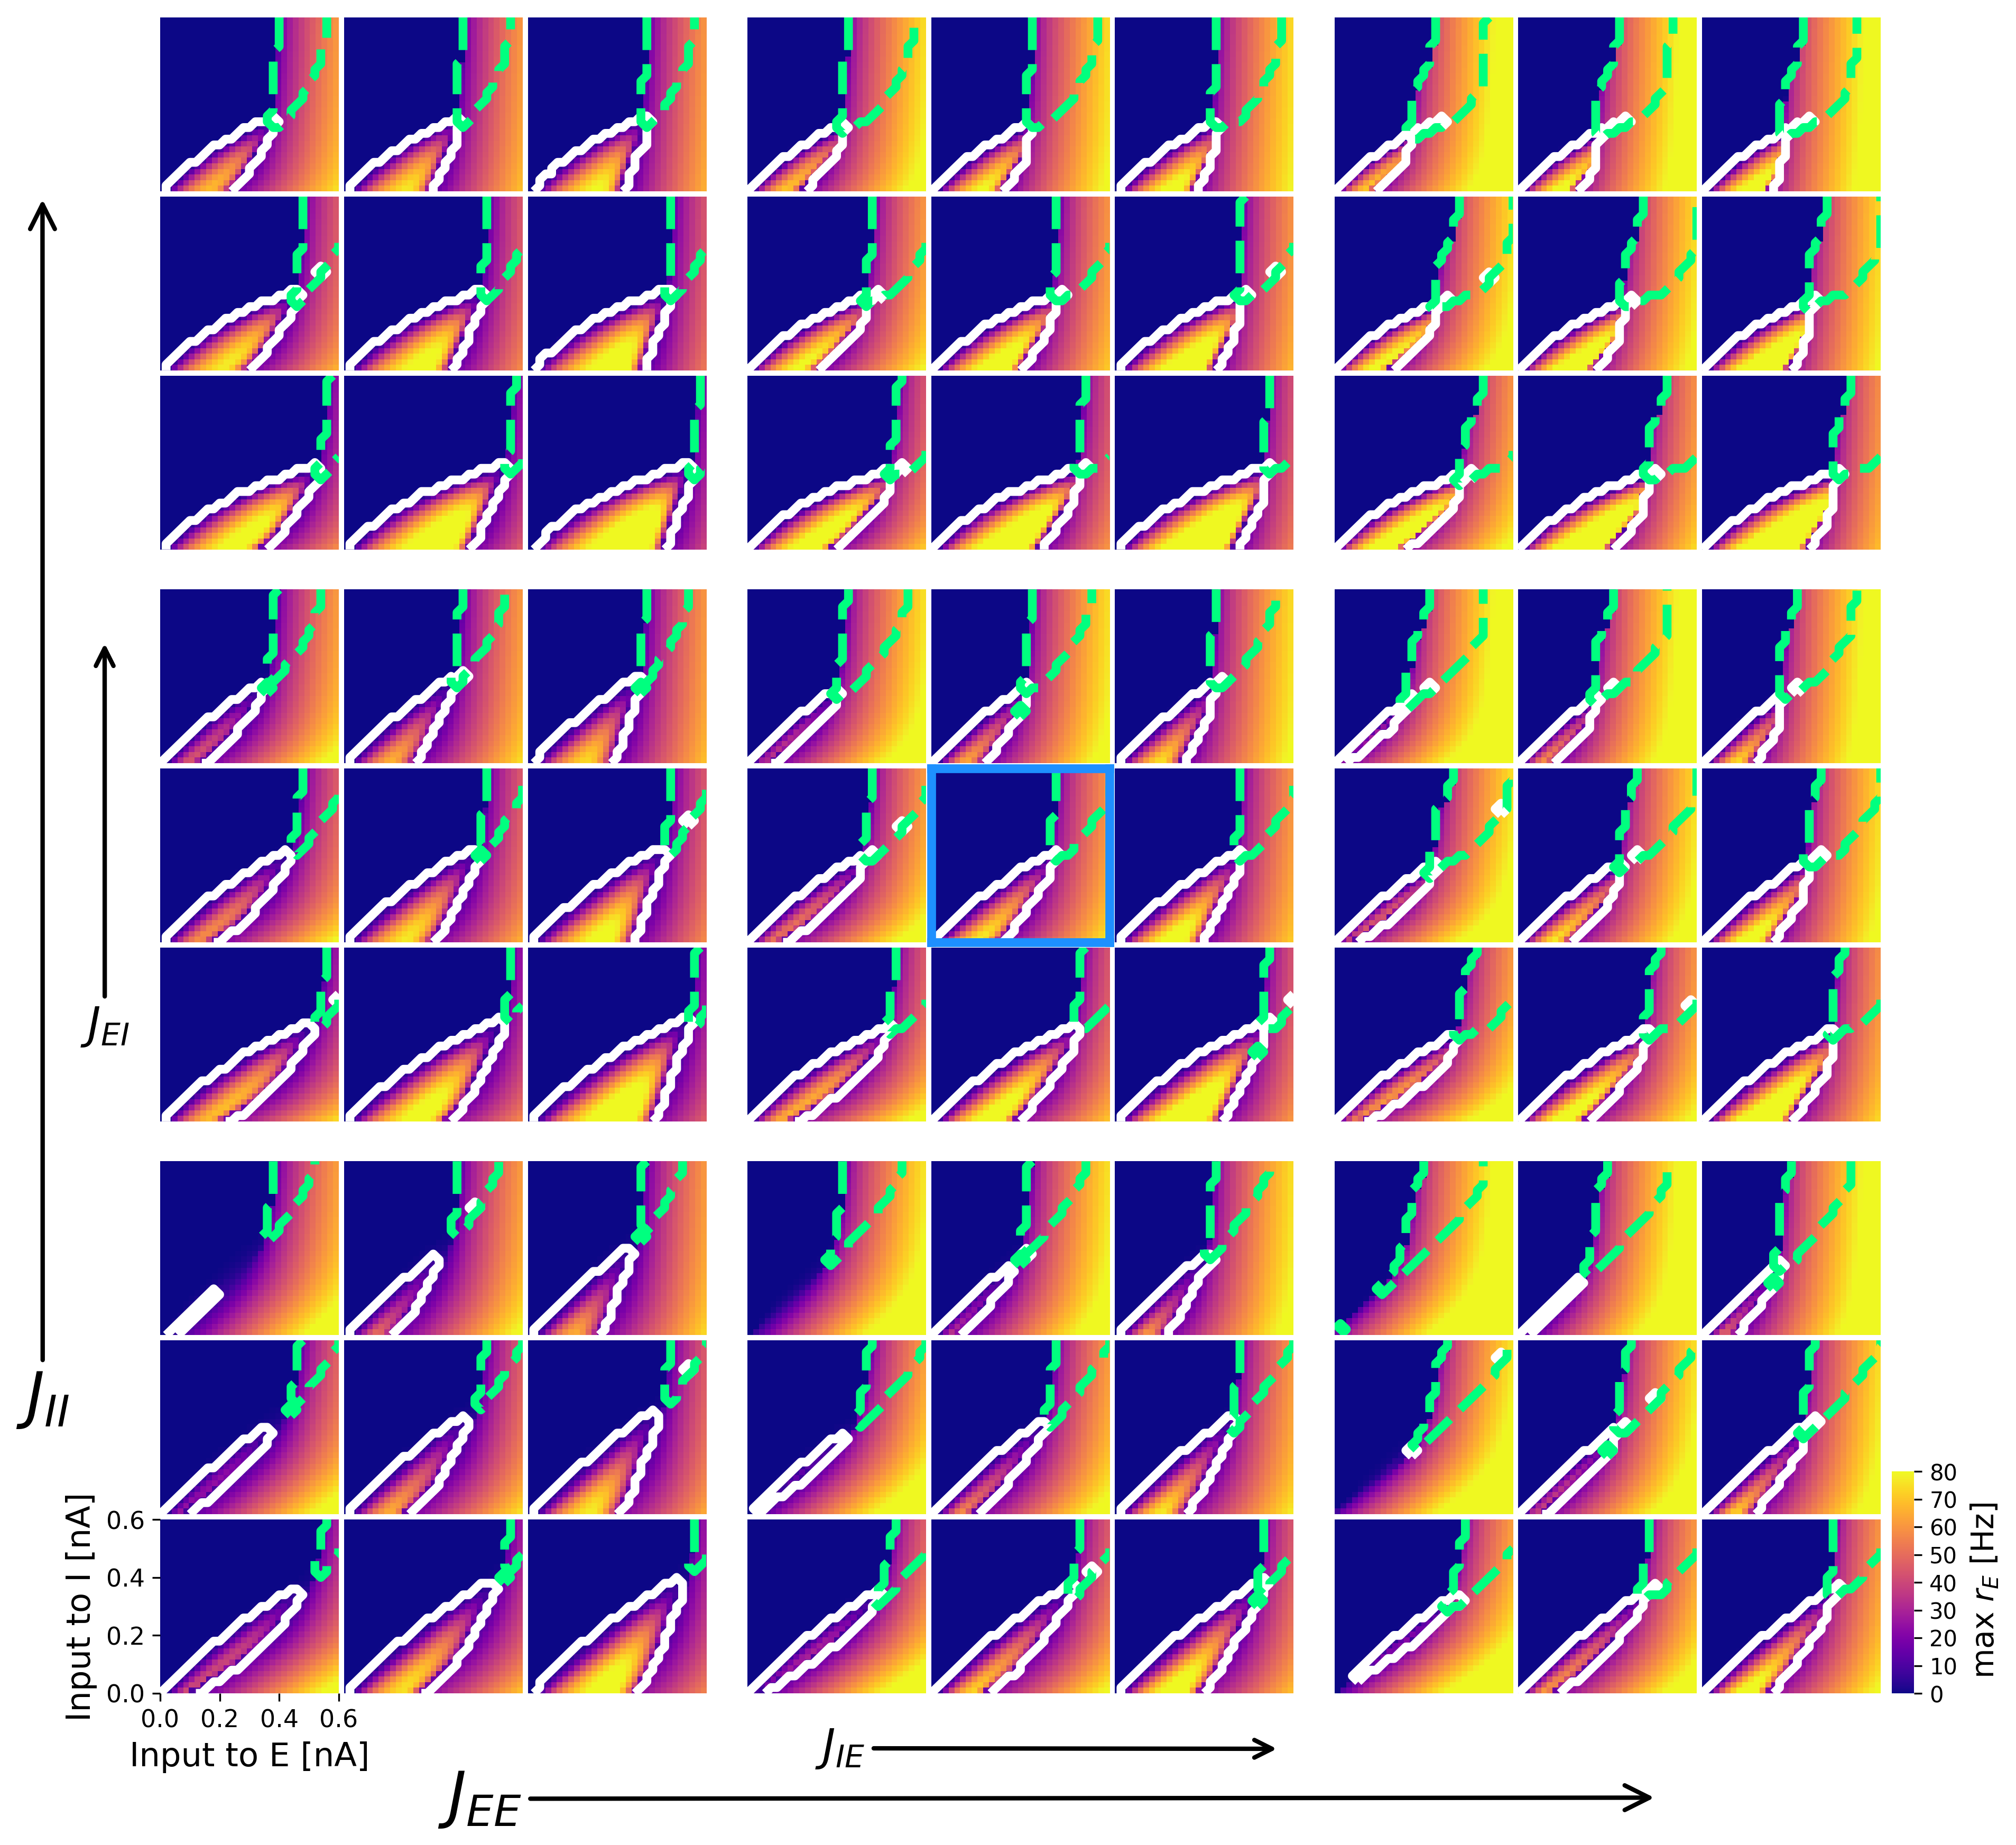

In [23]:
import matplotlib.gridspec as gridspec
import matplotlib.patheffects as PathEffects
import string
labels = [l for l in string.ascii_lowercase]

Jee_range = np.unique(dfResults.Jee_max)
Jii_range = np.unique(dfResults.Jii_max)
Jei_range = np.unique(dfResults.Jei_max)
Jie_range = np.unique(dfResults.Jie_max)

fig = plt.figure(figsize=(14, 14), dpi=300)
outer_grid = gridspec.GridSpec(len(Jee_range),len(Jii_range), wspace=0.075, hspace=0.075)

n_plot = -1

for yg, jii in enumerate(Jii_range): #zip(range(len(a_range))[::-1], a_range): 
    yg_flipped = len(Jii_range)-1-yg # flip for plotting, because gridspec (0,0) is upper left...
    for xg, jee in enumerate(Jee_range):
        #print(yg, xg, 'pars', 'Jee', jee, 'Jii', jii)
        wspace = 0.03
        hspace = 0.03
        if (xg, yg) == (1, 1):
            wspace, hspace = 0.03, 0.03
            
        inner_grid = gridspec.GridSpecFromSubplotSpec(len(Jei_range),len(Jie_range), subplot_spec=outer_grid[yg_flipped, xg], wspace=wspace, hspace=hspace)
        
        for ygi, jei in enumerate(Jei_range): #zip(range(len(a_range))[::-1], a_range): 
            ygi_flipped = len(Jei_range)-1-ygi # flip for plotting, because gridspec (0,0) is upper left...
            for xgi, jie in enumerate(Jie_range):
                n_plot+=1
                print("{}{}{}{} | {}: Plotting Jii {} Jee {} Jei {} Jie {}".format(yg, xg, ygi, xgi, n_plot, jii, jee, jei, jie))
                selector = (dfResults.Jee_max==jee) & (dfResults.Jii_max==jii) & (dfResults.Jei_max==jei) &(dfResults.Jie_max==jie)
                selectedResults = dfResults[selector]
                selectIndices = selectedResults.index
                
                if (yg, xg, ygi, xgi) == (1, 1, 1, 1): # make the axis of the middle plot thicker
                    plt.rc('axes', linewidth=4)
                else:
                    plt.rc('axes', linewidth=0)  
                    
                ax = plt.subplot(inner_grid[ygi_flipped, xgi]) # stupid: gridspec takes y first, then x ...
                imPlot = plotResults(selectedResults, 'max_exc', ax, (xg, yg, xgi, ygi))
                
                
                #ax.text(0.15, 0.85, n_plot, horizontalalignment='center', color='white', verticalalignment='center', transform=ax.transAxes)
#fig.tight_layout(pad=4.0, w_pad=0.5, h_pad=0.5)     


# colorbars
from mpl_toolkits.axes_grid1 import make_axes_locatable
cax=fig.add_axes([0.905,0.125,0.01,0.1])  ## the parameters are the specified position you set 
fig.colorbar(imPlot, cax=cax)
fig.text(0.94, 0.2, 'max $r_E$ [Hz]', rotation=90, color='black', size=14)

# outer grid a and b
bbox_props = dict(boxstyle="square,pad=0.1", fc="white", lw=1)
bbox_props = None

plt.annotate("$J_{EE}$",size=28, bbox=bbox_props,
            xy=(0.8, 0.078), xycoords=fig.transFigure,
            xytext=(0.25, 0.07), textcoords=fig.transFigure,                 
            arrowprops=dict(arrowstyle="->", lw=2))

plt.annotate("$J_{IE}$",size=20, bbox=bbox_props,
            xy=(0.63, 0.1), xycoords=fig.transFigure,
            xytext=(0.42, 0.095), textcoords=fig.transFigure,                 
            arrowprops=dict(arrowstyle="->", lw=2))
#plt.annotate("Spike-triggered adaptation [pA]", size=18, xy=(0.4, 0.04), xycoords=fig.transFigure)

plt.annotate("$J_{II}$",size=28, bbox=bbox_props,
            xy=(0.072, 0.8), xycoords=fig.transFigure,
            xytext=(0.06, 0.25), textcoords=fig.transFigure,                 
            arrowprops=dict(arrowstyle="->", lw=2))

plt.annotate("$J_{EI}$",size=20, bbox=bbox_props,
            xy=(0.1, 0.6), xycoords=fig.transFigure,
            xytext=(0.089, 0.42), textcoords=fig.transFigure,                 
            arrowprops=dict(arrowstyle="->", lw=2))

#plt.annotate("Subthreshold adaptation [nS]", size=18, xy=(0.02, 0.66), rotation=90, xycoords=fig.transFigure)